<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning2/blob/master/Transformer_FineTuning/imdb_sentiment_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Overview
In this notebook, we create a custom MultiHeadSelfAttention class
and use it to classify the sentiment in the classic IMDB dataset.

In [2]:
!nvidia-smi

Tue Dec 15 19:37:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Implement multi-head self attention as a Keras layer

In [3]:
class MultiHeadSelfAttention(layers.Layer):
  def __init__(self, embed_dim, num_heads=8):
    super(MultiHeadSelfAttention, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    if embed_dim % num_heads != 0:
      raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads: {num_heads}")
    self.projection_dim = embed_dim // num_heads
    self.query_dense = layers.Dense(embed_dim)
    self.key_dense = layers.Dense(embed_dim)
    self.value_dense = layers.Dense(embed_dim)
    self.combine_heads = layers.Dense(embed_dim)

  def attention(self, query, key, value):
    score = tf.matmul(query, key, transpose_b=True)
    dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_score = score / tf.math.sqrt(dim_key)
    weights = tf.nn.softmax(scaled_score, axis=-1)
    output = tf.matmul(weights, value)
    return output, weights

  def separate_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    query = self.query_dense(inputs)
    key = self.key_dense(inputs)
    value = self.value_dense(inputs)
    
    query = self.separate_heads(query, batch_size)
    key = self.separate_heads(key, batch_size)
    value = self.separate_heads(value, batch_size)
    attention, weights = self.attention(query, key, value)
    attention = tf.transpose(attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
    output = self.combine_heads(concat_attention)
    return output

Implement a transformer block as a layer

In [4]:
class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadSelfAttention(embed_dim, num_heads)
    self.ffn = keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

Implement embedding layer

In [5]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

Download and prepare dataset

In [6]:
vocab_size = 20000
maxlen = 200
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


Create a classifier model using transformer layers

In [7]:
# Embedding size for each token
embed_dim = 32 
# Number of attention heads
num_heads = 2
# Hidden layer size of feed forward network inside Transformer
ff_dim = 32

# Prepend embedding layer and append feed forward layers to the transformer block
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dense(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

# 
model = keras.Model(inputs=inputs, outputs=outputs)


In [8]:
x_val[0].shape

(200,)

In [9]:
y_val[0]

0

In [10]:
# Compile and run
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
782/782 [==============================] - 17s 22ms/step - loss: 0.3776 - accuracy: 0.8185 - val_loss: 0.2902 - val_accuracy: 0.8753
Epoch 2/20
782/782 [==============================] - 16s 20ms/step - loss: 0.1966 - accuracy: 0.9222 - val_loss: 0.3116 - val_accuracy: 0.8725
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 0.1312 - accuracy: 0.9527 - val_loss: 0.4015 - val_accuracy: 0.8584
Epoch 4/20
782/782 [==============================] - 16s 20ms/step - loss: 0.0830 - accuracy: 0.9718 - val_loss: 0.5470 - val_accuracy: 0.8546
Epoch 5/20
782/782 [==============================] - 15s 20ms/step - loss: 0.0548 - accuracy: 0.9824 - val_loss: 0.6014 - val_accuracy: 0.8370
Epoch 6/20
782/782 [==============================] - 16s 20ms/step - loss: 0.0436 - accuracy: 0.9856 - val_loss: 0.6436 - val_accuracy: 0.8432
Epoch 7/20
782/782 [==============================] - 16s 20ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.7971 - val_accuracy:

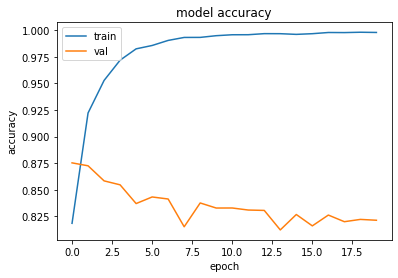

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

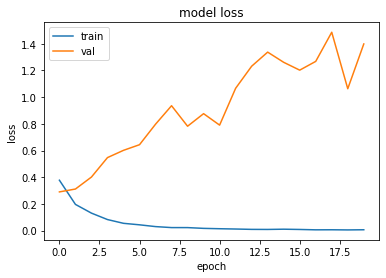

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()